### Training calibration network(s)

In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.multiprocessing as mp
from torch.distributed import init_process_group, destroy_process_group
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
from astropy.io import fits
import pyxis.torch as pxt
import pyxis as px
import scipy.optimize as so

from networks import *
from train import *
from dataset import *
import config

stem = 'test_1m_baseline'
data_dir = f'/xdisk/timeifler/wxs0703/kl_nn/test_data/test_database_{stem}'
fig_dir = '/xdisk/timeifler/wxs0703/kl_nn/figures/'
model_dir = f'/xdisk/timeifler/wxs0703/kl_nn/model/{stem}'
cali_dir = '/home/wxs0703/cali'

#### First, we have to run all training and validation data through our trained CNN to make feature measurements

In [2]:
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "12356"
torch.cuda.set_device(0)
init_process_group(backend='nccl', rank=0, world_size=1)

In [3]:
model_file = join(model_dir, f'{stem}36')
model = load_model(path=model_file,strict=True, assign=True)

/home/u2/wxs0703/Eifler/kl-nn/cnn/modules/train.py:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path), strict=strict, assign=assign)


In [4]:
# Get data loader
train_ds = pxt.TorchDataset(config.cali['train_dir'])
train_dl = DataLoader(train_ds,
                      batch_size=100,
                      pin_memory=True,
                      shuffle=False,)

valid_ds = pxt.TorchDataset(config.cali['valid_dir'])
valid_dl = DataLoader(valid_ds,
                     batch_size=100,
                     pin_memory=True,
                     shuffle=False,)

In [5]:
train_pred, train_true, train_loss = predict(9, train_dl, model)
print('Train LOSS:', train_loss)
valid_pred, valid_true, valid_loss = predict(9, valid_dl, model)
print('Valid LOSS:', valid_loss)

Train LOSS: 0.14436118941126022
Valid LOSS: 0.14484502176078312


In [4]:
destroy_process_group()

In [6]:
# Extract SNR in input order
n_train = config.cali['train_size']
SNR_train = np.zeros((n_train,1), dtype=np.float32)
with px.Reader(config.cali['train_dir']) as db:
    for i in range(n_train):
        SNR_train[i] = db[i]['SNR']

n_valid = config.cali['valid_size']
SNR_valid = np.zeros((n_valid,1), dtype=np.float32)
with px.Reader(config.cali['valid_dir']) as db:
    for i in range(n_valid):
        SNR_valid[i] = db[i]['SNR']

# Calculate g magnitude
g_train_pred = np.expand_dims(np.sqrt(train_pred[:, 1]**2 + train_pred[:, 2]**2), 1)
g_valid_pred = np.expand_dims(np.sqrt(valid_pred[:, 1]**2 + valid_pred[:, 2]**2), 1)
g_train_true = np.expand_dims(np.sqrt(train_true[:, 1]**2 + train_true[:, 2]**2), 1)
g_valid_true = np.expand_dims(np.sqrt(valid_true[:, 1]**2 + valid_true[:, 2]**2), 1)

In [7]:
# Append SNR to CNN output and true values
train_input = np.concatenate((train_pred, SNR_train/250, g_train_pred), axis=1)
valid_input = np.concatenate((valid_pred, SNR_valid/250, g_valid_pred), axis=1)
train_true = np.concatenate((train_true, SNR_train/250, g_train_true), axis=1)
valid_true = np.concatenate((valid_true, SNR_valid/250, g_valid_true), axis=1)

In [8]:
# Separate into cases and realizations
# Cases separated by shear and SNR
split_pars = ['g', 'SNR']
nsplits = [10, 10]
ncases = np.prod(nsplits)
train_true_df = pd.DataFrame(train_true, columns=['ID', 'g1', 'g2', 'sini', 'v0', 'vcirc', 'rscale', 'SNR', 'g'])
valid_true_df = pd.DataFrame(valid_true, columns=['ID', 'g1', 'g2', 'sini', 'v0', 'vcirc', 'rscale', 'SNR', 'g'])

In [9]:
# Compute indices for case bins
grids = [np.arange(0, n, dtype=int) for n in nsplits]
G = np.meshgrid(*grids)
indices = np.stack([g.flatten() for g in G], axis=1)

In [10]:
# sort dataframes to more efficiently section cases by parameters
train_sorted = []
valid_sorted = []
for par in split_pars:
    train_sorted.append(train_true_df.sort_values(par, inplace=False))
    valid_sorted.append(valid_true_df.sort_values(par, inplace=False))

In [11]:
# Function to group galaxies of one case
def group_case(size, split_pars, nsplits, ind, sort):
    ids = []
    for i, n in enumerate(ind):
        start = n*size//nsplits[i]
        end = (n+1)*size//nsplits[i]
        ids.append(sort[i]['ID'][start:end].astype(int))
    while len(ids) > 1:
        ids[0] = np.intersect1d(ids[0], ids[1], assume_unique=True)
        ids.pop(1)
    selection = train_true_df.iloc[ids[0]].to_numpy()
    group = selection[:, 1:-1]
    ids = selection[:, 0]
    return group, ids

In [12]:
tot = 0
for ind in indices:
    grp, ids = group_case(n_train, split_pars, nsplits, ind, train_sorted)
    tot += grp.shape[0]

In [13]:
nfeatures = config.cali['feature_number']
nreal_train = n_train//ncases
nreal_valid = n_valid//ncases
train_true_db = np.full((n_train, nfeatures), 0.)
valid_true_db = np.full((n_valid, nfeatures), 0.)
train_ids = np.zeros((n_train))
valid_ids = np.zeros((n_valid))

# Create training database
start = 0
for case, ind in enumerate(indices):
    train_grp, tids = group_case(n_train, split_pars, nsplits, ind, train_sorted)
    grp_len = tids.shape[0]
    train_true_db[start:start+grp_len] = train_grp
    train_ids[start:start+grp_len] = tids
    start += grp_len
train_true_db = np.reshape(train_true_db, (ncases, nreal_train, nfeatures))
train_ids = np.reshape(train_ids, (ncases, nreal_train))

# Create validation database
start = 0
for case, ind in enumerate(indices):
    valid_grp, vids = group_case(n_valid, split_pars, nsplits, ind, valid_sorted)
    grp_len = vids.shape[0]
    valid_true_db[start:start+grp_len] = valid_grp
    valid_ids[start:start+grp_len] = vids
    start += grp_len
valid_true_db = np.reshape(valid_true_db, (ncases, nreal_valid, nfeatures))
valid_ids = np.reshape(valid_ids, (ncases, nreal_valid))

In [21]:
train_input_db = train_input[train_ids.astype(int), 1:-1]
valid_input_db = valid_input[valid_ids.astype(int), 1:-1]

In [22]:
# Save CNN output (CaliNN inputs) and true values
np.save(join(cali_dir, 'train_input'), train_input_db)
np.save(join(cali_dir, 'valid_input'), valid_input_db)
np.save(join(cali_dir, 'train_true'), train_true_db)
np.save(join(cali_dir, 'valid_true'), valid_true_db)
np.save(join(cali_dir, 'train_ids'), train_ids)
np.save(join(cali_dir, 'valid_ids'), valid_ids)

### Train model (test code)

In [16]:
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "12356"
torch.cuda.set_device(0)
init_process_group(backend='nccl', rank=0, world_size=1)

In [12]:
batch_size = 100
ncases = 100
nreal_train = 2000
nreal_valid = 1000
nepochs = 20

In [4]:
torch.cuda.is_available()

True

In [5]:
train_datasets = []
valid_datasets = []
for case in range(ncases):
    train_datasets.append(CaliDataset(case,
                                      join(cali_dir, 'train_input.npy'),
                                      join(cali_dir, 'train_true.npy'),
                                      join(cali_dir, 'train_ids.npy')))
    valid_datasets.append(CaliDataset(case,
                                      join(cali_dir, 'valid_input.npy'),
                                      join(cali_dir, 'valid_true.npy'),
                                      join(cali_dir, 'valid_ids.npy')))

In [6]:
train_dataloaders = []
valid_dataloaders = []
for case in range(ncases):
    train_dataloaders.append(DataLoader(train_datasets[case],
                                        batch_size=batch_size,
                                        pin_memory=True,
                                        shuffle=False))
    valid_dataloaders.append(DataLoader(valid_datasets[case],
                                        batch_size=batch_size,
                                        pin_memory=True,
                                        shuffle=False))

In [7]:
model = CaliNN()
model.to(0)
model = DDP(model, device_ids=[0])

In [8]:
optimizer = optim.LBFGS(model.parameters(),
                        lr=config.cali['learning_rate'],
                        history_size=10,
                        max_iter=4, 
                        line_search_fn="strong_wolfe")

In [9]:
def closure():
    optimizer.zero_grad()
    loss = run_iter(train_dataloaders, nreal_train)
    loss.backward()
    return loss

In [10]:
def run_iter(dataloaders, nreal):
    
    losses = torch.full((ncases, 2), 0.).to(0)
    
    for case in range(ncases):
    
        dl = dataloaders[case]
        case_loss = torch.tensor([0., 0.]).to(0)

        for i, batch in enumerate(dl):
            inputs = batch['inputs'].float().to(0)
            target = batch['target'].float().to(0)
            outputs = model(inputs)
            loss = torch.sum(torch.abs(outputs-target), dim=0).to(0)
            case_loss += torch.sum(loss, dim=0)
        
        losses[case] = (case_loss / nreal)**2
    
    loss = torch.sum(losses)/(2*ncases)
    
    return loss

In [11]:
train_history = []
valid_history = []

for i in range(nepochs):
    
    model.train()
    train_loss = run_iter(train_dataloaders, nreal_train).cpu().item()
    train_history.append(train_loss)
    optimizer.step(closure)
    print(f"[TRAIN] epoch {i+1} loss: {train_loss}")
    
    model.eval()
    valid_loss = run_iter(valid_dataloaders, nreal_valid).cpu().item()
    valid_history.append(valid_loss)
    print(f"[VALID] epoch {i+1} loss: {valid_loss}")
    
    ckp = model.module.state_dict()
    PATH = join(cali_dir, f'test/test_model_{i+1}')
    torch.save(ckp, PATH)
    

[TRAIN] epoch 1 loss: 0.2965713143348694
[VALID] epoch 1 loss: 0.25005775690078735
[TRAIN] epoch 2 loss: 0.2554642856121063
[VALID] epoch 2 loss: 0.22377997636795044
[TRAIN] epoch 3 loss: 0.2291661649942398
[VALID] epoch 3 loss: 0.1957792192697525
[TRAIN] epoch 4 loss: 0.20113815367221832
[VALID] epoch 4 loss: 0.18987205624580383
[TRAIN] epoch 5 loss: 0.19504663348197937
[VALID] epoch 5 loss: 0.1875588744878769
[TRAIN] epoch 6 loss: 0.1924661546945572
[VALID] epoch 6 loss: 0.1849634349346161
[TRAIN] epoch 7 loss: 0.18920497596263885
[VALID] epoch 7 loss: 0.18212756514549255
[TRAIN] epoch 8 loss: 0.1838551163673401
[VALID] epoch 8 loss: 0.1821250170469284
[TRAIN] epoch 9 loss: 0.1829952597618103
[VALID] epoch 9 loss: 0.18243253231048584
[TRAIN] epoch 10 loss: 0.18153361976146698
[VALID] epoch 10 loss: 0.18502475321292877
[TRAIN] epoch 11 loss: 0.17751380801200867
[VALID] epoch 11 loss: 0.19571062922477722
[TRAIN] epoch 12 loss: 0.1698787659406662
[VALID] epoch 12 loss: 0.213394746184349

In [13]:
epochs = np.linspace(1, nepochs, nepochs)

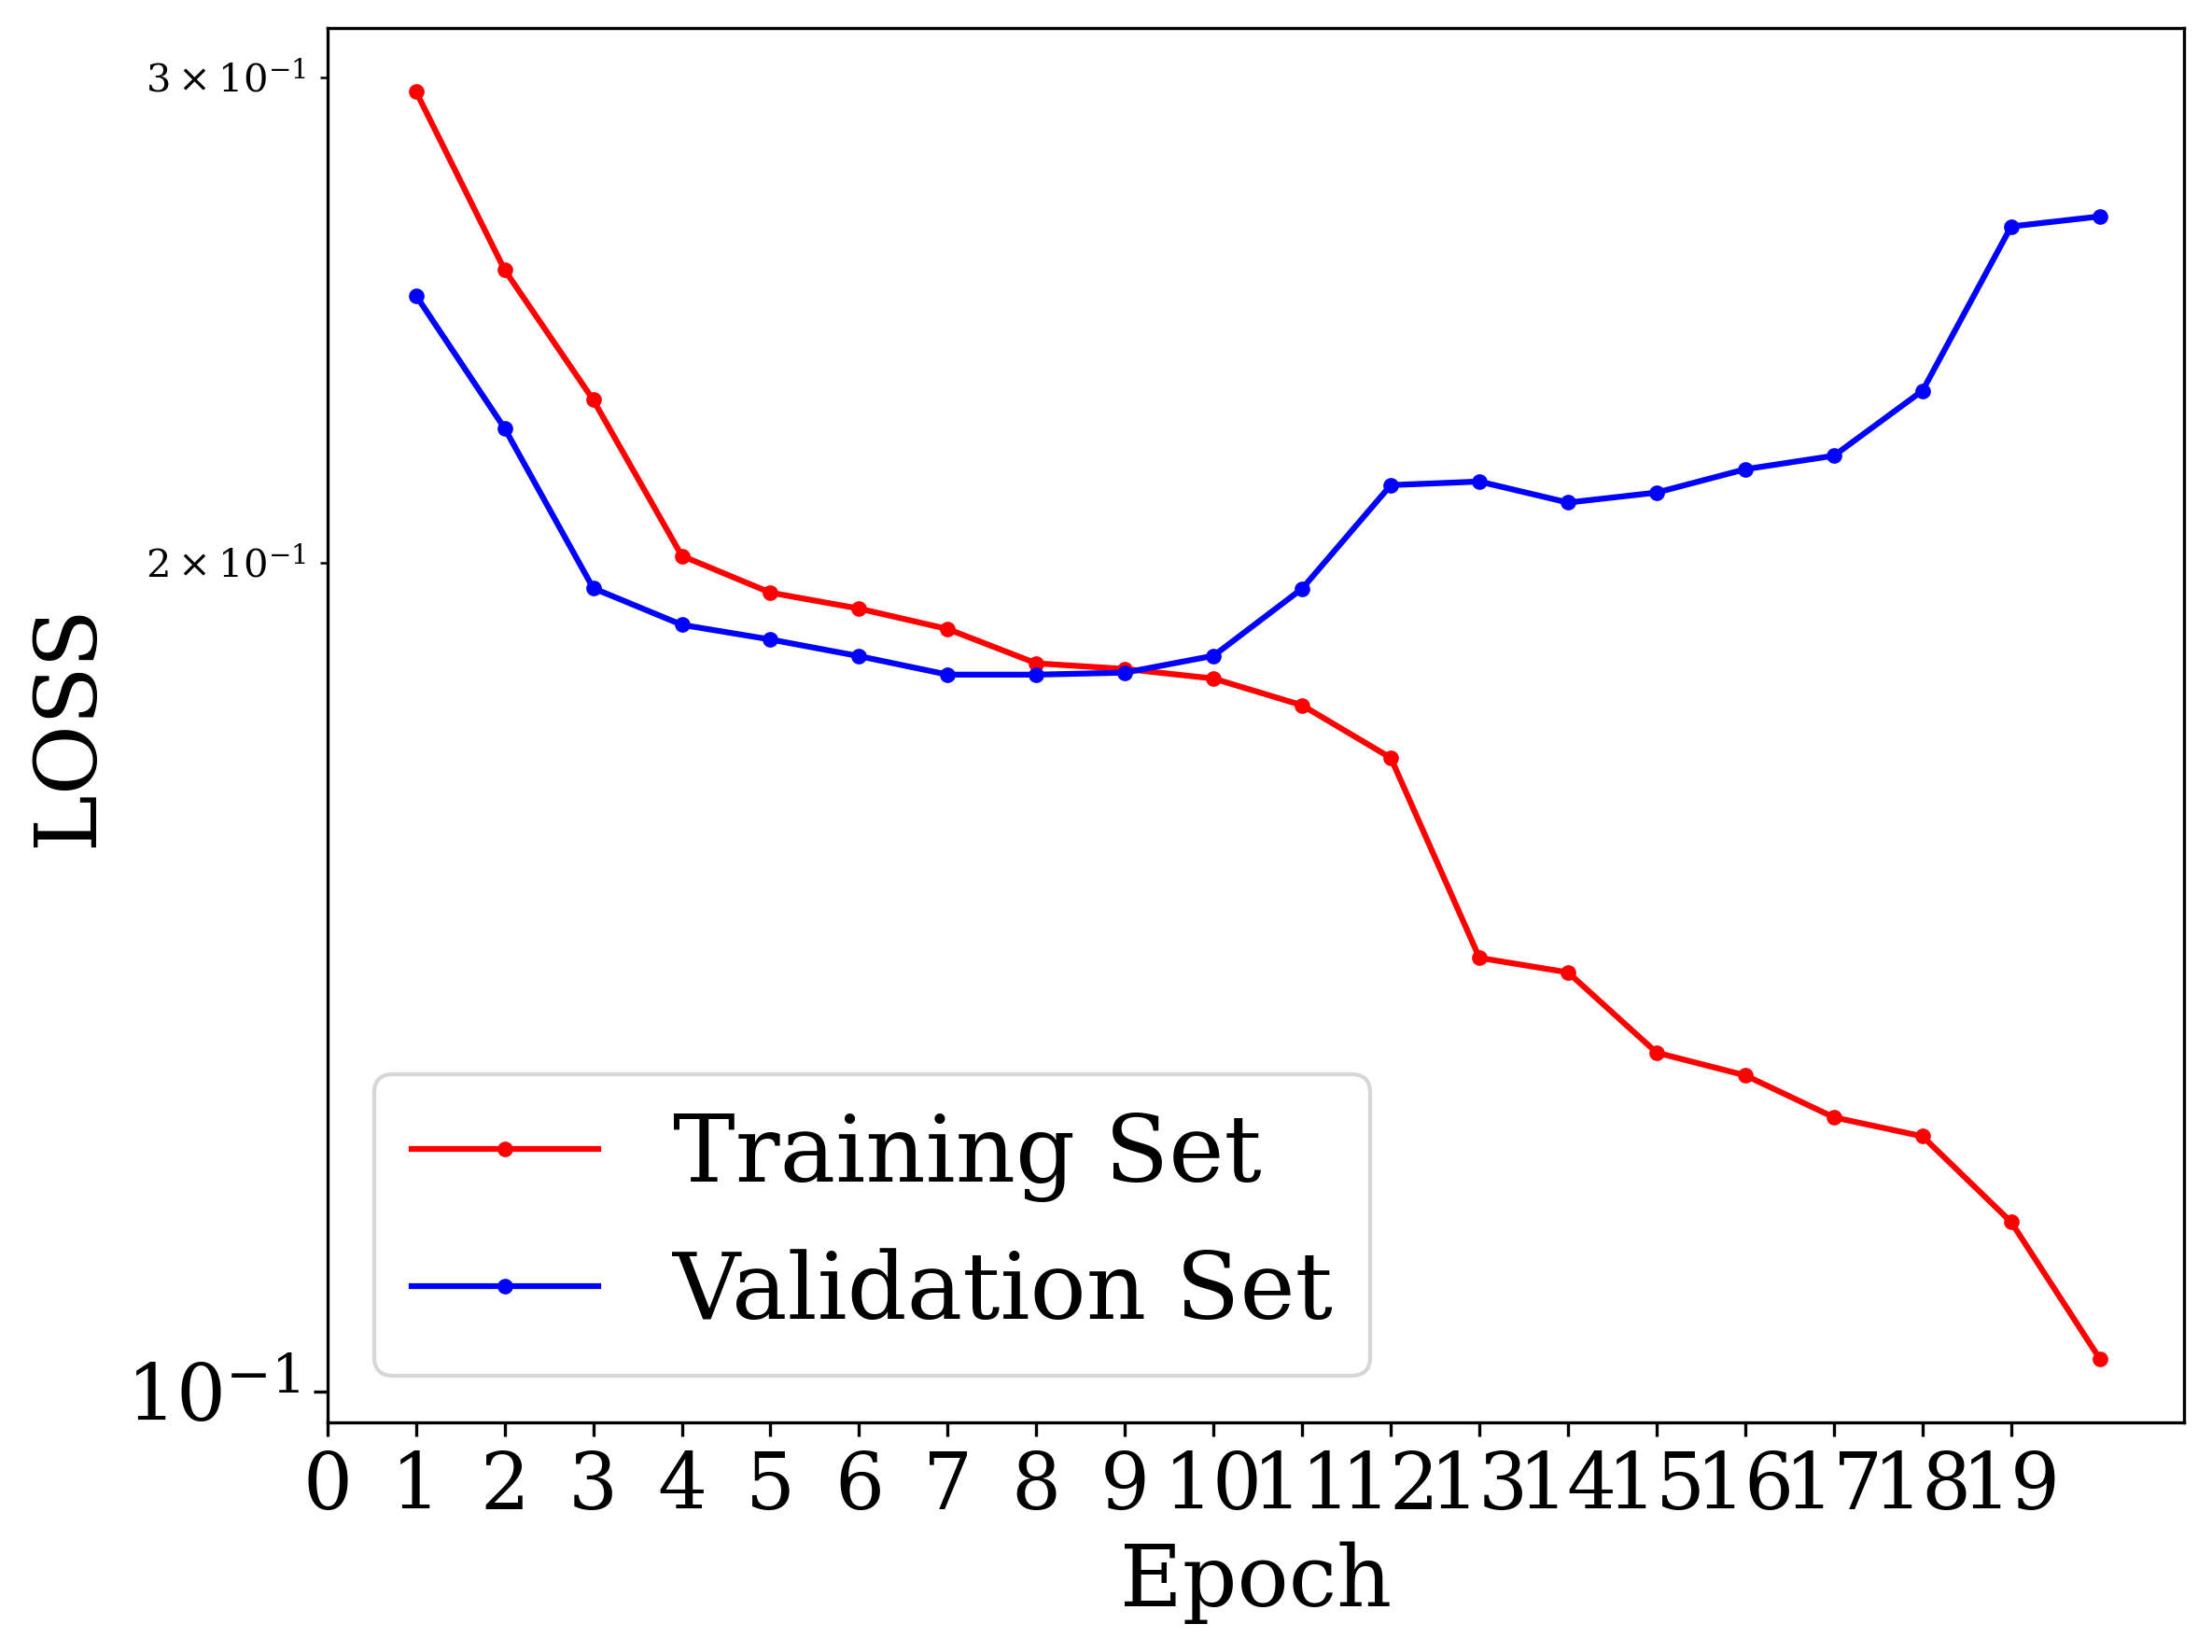

In [14]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
plt.figure(figsize=(8, 6))

plt.semilogy(epochs, train_history, 'r.-', label="Training Set")
plt.semilogy(epochs, valid_history, 'b.-', label='Validation Set')

plt.xlabel("Epoch", fontsize=22)
plt.ylabel("LOSS", fontsize=22)
plt.tick_params(axis='both',which='major',labelsize=20)
plt.xticks(np.arange(0, nepochs, 1))
plt.legend(fontsize=24)
plt.tight_layout()
#plt.savefig(join(fig_dir, f'losses/{stem}_loss.jpg'))
plt.show()

In [22]:
def load_model(Model=CaliNN, path=None, strict=True, assign=False):

    model = Model(config.cali['feature_number'])
    model.to(0)
    if path != None:
        model.load_state_dict(torch.load(path), strict=strict, assign=assign)

    return model

In [23]:
model_file = join(cali_dir, f'test/test_model_8')
model = load_model(Model=CaliNN, path=model_file,strict=True, assign=True)

/tmp/ipykernel_3545705/3087738166.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path), strict=strict, assign=assign)


In [24]:
def predict(dataloaders, nreal):
    
    losses = torch.full((ncases, 2), 0.).to(0)
    pred = []
    true = []
    
    for case in range(ncases):
    
        dl = dataloaders[case]
        case_loss = torch.tensor([0., 0.]).to(0)

        for i, batch in enumerate(dl):
            inputs = batch['inputs'].float().to(0)
            target = batch['target'].float().to(0)
            outputs = model(inputs)
            pred.append(outputs.detach().cpu().numpy())
            true.append(target.detach().cpu().numpy())
            loss = torch.sum(torch.abs(outputs-target), dim=0).to(0)
            case_loss += torch.sum(loss, dim=0)
        
        losses[case] = (case_loss / nreal)**2
    
    loss = (torch.sum(losses)/(2*ncases)).cpu().item()
    pred = np.reshape(np.stack(pred, axis=0), (nreal*ncases, 2))
    true = np.reshape(np.stack(true, axis=0), (nreal*ncases, 2))
    
    return pred, true, loss

In [25]:
model.eval()
pred, true, test_loss = predict(valid_dataloaders, nreal_valid)
print(f"Test loss: {test_loss}")

Test loss: 0.18243253231048584


In [26]:
destroy_process_group()

In [27]:
par_ranges = \
{
    'g1': [-0.1, 0.1],
    'g2': [-0.1, 0.1],
}

In [28]:
def denormalize(samples):
    denorm = np.empty_like(samples)
    denorm[:, 0] = samples[:, 0]
    for i, par in enumerate(par_ranges.values()):
        low, high = par
        values = samples[:, i]
        values *= high-low
        values += low
        denorm[:, i] = values
    return denorm

In [29]:
pred_den = denormalize(pred)
true_den = denormalize(true)

In [30]:
diff = pred_den - true_den

In [31]:
fig_dir = '/home/wxs0703/cali/test'

In [32]:
def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
         colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), density=True)
    # NOTE : if you are using the latest version of python, in the above: 
    # instead of normed=True, use density=True
    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    
    ### Adjust Here #### 
    
    # Contour Levels Definitions
    zero = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.))
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))


    # Array of Contour levels. Adjust according to the above
    levels = [zero, one_sigma, two_sigma][::-1]

    ###### 
    
    if ax == None:
        contour = plt.contourf(X, Y, Z, levels=levels, origin="lower", alpha=0.5, **contour_kwargs)

    else:
        contour = ax.contourf(X, Y, Z, levels=levels, origin="lower", alpha=0.5, **contour_kwargs)
    
    return contour

<Figure size 2400x1800 with 0 Axes>

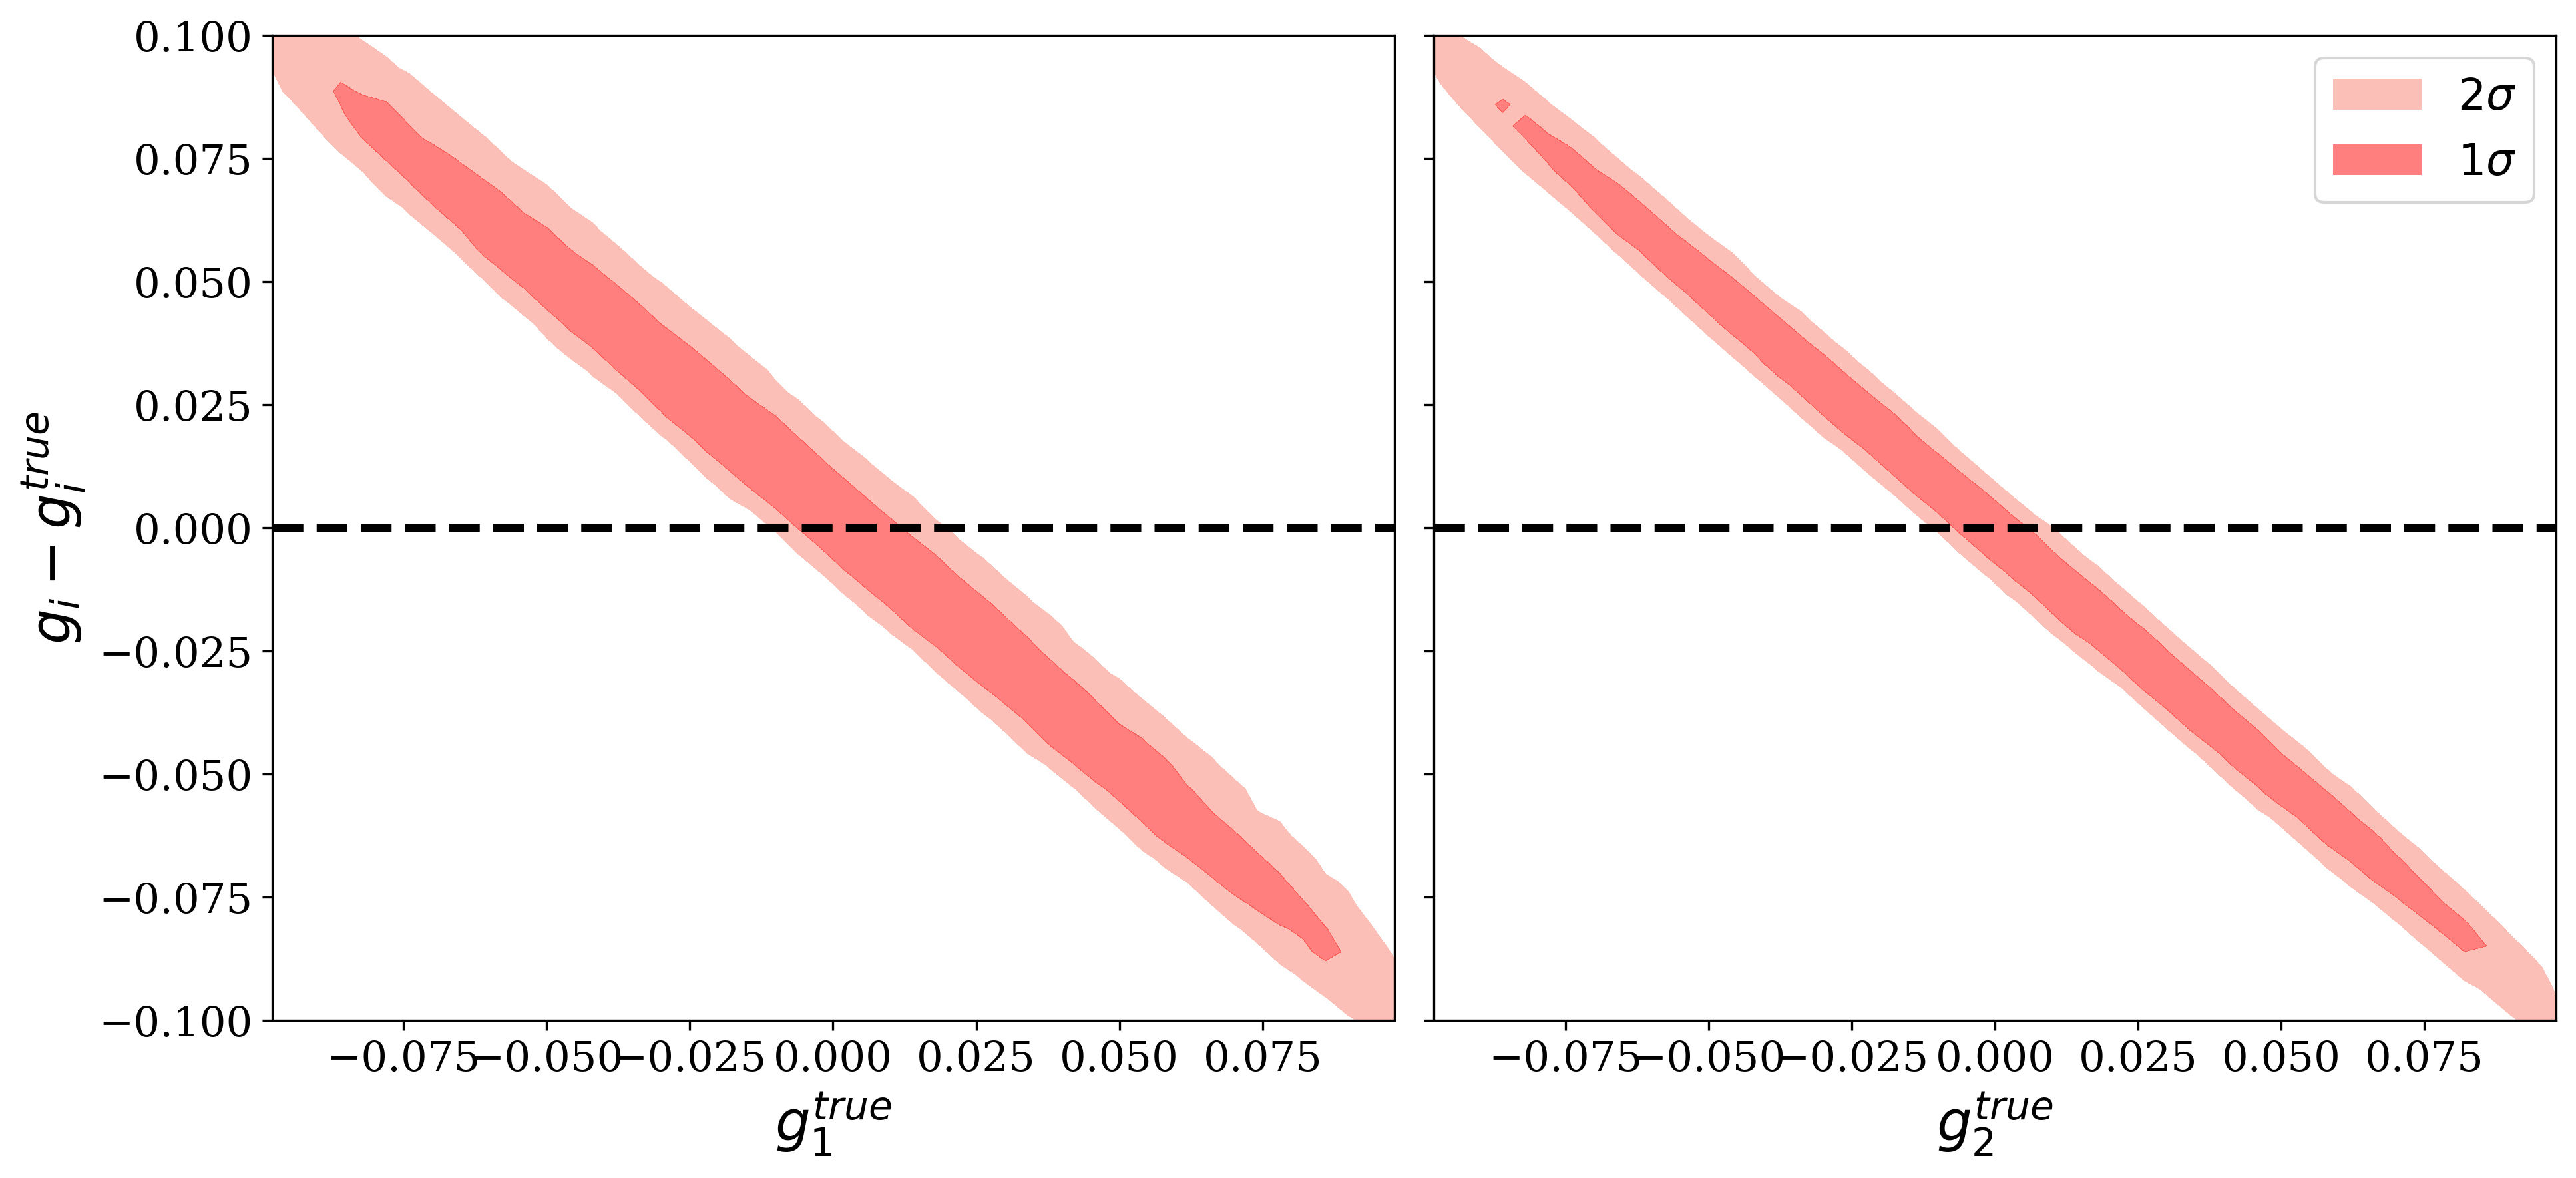

In [34]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
fig = plt.figure(figsize=(8,6))
fig1,axes = plt.subplots(1,2,sharey=True,figsize=(13,6))

g1_true = true_den[:,0]
g1_diff = diff[:,0]
g2_true = true_den[:,1]
g2_diff = diff[:,1]
density_contour(g1_true, g1_diff, 50, 50, ax=axes[0], colors=['salmon', 'red'])
contour = density_contour(g2_true, g2_diff, 50, 50, ax=axes[1], colors=['salmon', 'red'])
axes[0].set_ylim(-0.1, .1)

for i in range(2):
    axes[i].axhline(0,color='k',linestyle='--',linewidth=3)
    
axes[0].set_xlabel(r'$g_1^{true}$',fontsize=20)
axes[1].set_xlabel(r'$g_2^{true}$',fontsize=20)
axes[0].set_ylabel(r'$g_i-g_i^{true}$',fontsize=20)

axes[0].tick_params(axis='both',which='major',labelsize=15)
axes[1].tick_params(axis='x',which='major',labelsize=15)

handles, labels = contour.legend_elements()
axes[1].legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

fig1.subplots_adjust(wspace=0.08,hspace=0.06)

fig1.subplots_adjust(right=0.8)

plt.tight_layout()
plt.savefig(join(fig_dir, f'g_{stem}_contour.jpg'))
plt.show()

In [31]:
dividers = [0.2, 0.2, 1, 60, 480, 9.9]

In [32]:
avg_diff = np.average(np.abs(diff), axis=0)
avg_diff[1:] /= dividers
print(avg_diff)
np.save(join(results_dir, f'avgdiff_{stem}'), avg_diff)

[0.         0.11592608 0.11611942 0.02485971 0.01222006 0.152847
 0.14356875]
